In [2]:
#SOURCE: https://www.kaggle.com/code/databeru/fish-classifier-grad-cam-viz-acc-99-89/notebook

In [3]:
#imports
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import tensorflowjs as tfjs

In [4]:
image_dir = Path('../classifier/Fish_Dataset/')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [5]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,..\classifier\Fish_Dataset\Sea Bass\Sea Bass\0...,Sea Bass
1,..\classifier\Fish_Dataset\Gilt-Head Bream\Gil...,Gilt-Head Bream
2,..\classifier\Fish_Dataset\Sea Bass\Sea Bass\0...,Sea Bass


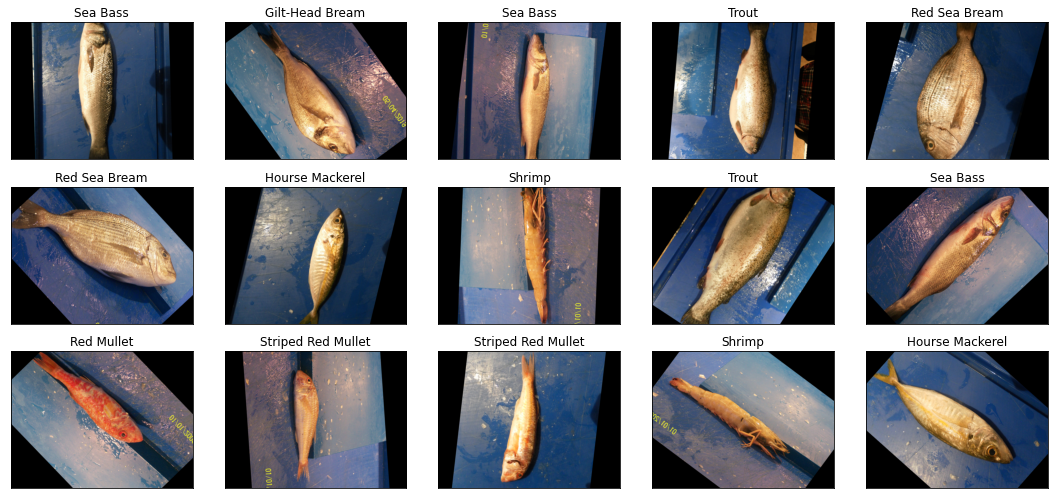

In [6]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [7]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [10]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [11]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
203/203 [==============================] - 92s 422ms/step - loss: 0.1626 - accuracy: 0.9554 - val_loss: 0.0324 - val_accuracy: 0.9883
Epoch 2/50
203/203 [==============================] - 53s 262ms/step - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.0084 - val_accuracy: 0.9975
Epoch 3/50
203/203 [==============================] - 55s 270ms/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.0050 - val_accuracy: 0.9988
Epoch 4/50
203/203 [==============================] - 52s 259ms/step - loss: 8.3232e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 0.9994
Epoch 5/50
203/203 [==============================] - 51s 252ms/step - loss: 3.5709e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 6/50
203/203 [==============================] - 51s 250ms/step - loss: 2.2292e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/50
203/203 [==============================] - 52s 255ms/step - loss: 1.6489e-04 - accuracy: 1.0000 - val_loss:

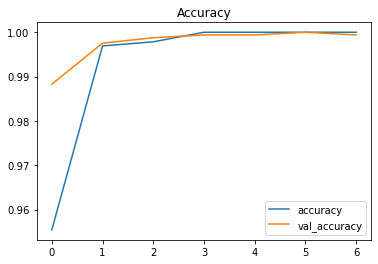

In [12]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

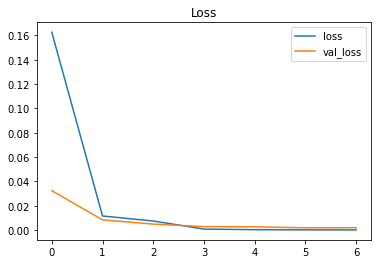

In [13]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [14]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00182
Test Accuracy: 100.00%


In [15]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

29/29 [==============================] - 6s 200ms/step
The first 5 predictions: ['Red Sea Bream', 'Red Mullet', 'Red Mullet', 'Red Sea Bream', 'Striped Red Mullet']


In [17]:
# Saving the model for later usage

model.save('../classifier/model.h5')
tfjs.converters.save_keras_model(model, '../classifier/model')


In [18]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        78
   Gilt-Head Bream       1.00      1.00      1.00       101
   Hourse Mackerel       1.00      1.00      1.00       102
        Red Mullet       1.00      1.00      1.00       105
     Red Sea Bream       1.00      1.00      1.00       113
          Sea Bass       1.00      1.00      1.00       101
            Shrimp       1.00      1.00      1.00       105
Striped Red Mullet       1.00      1.00      1.00       114
             Trout       1.00      1.00      1.00        81

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



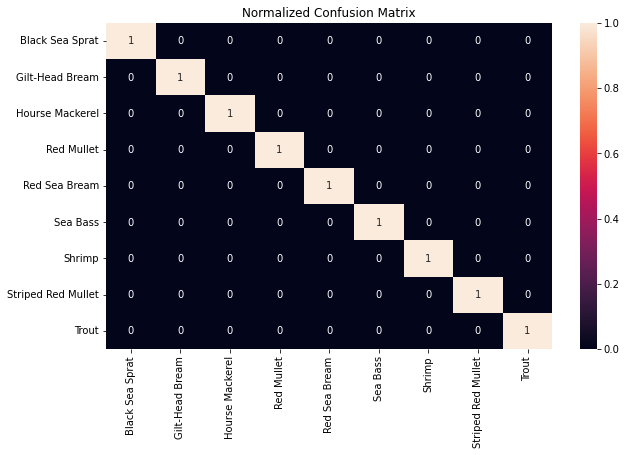

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

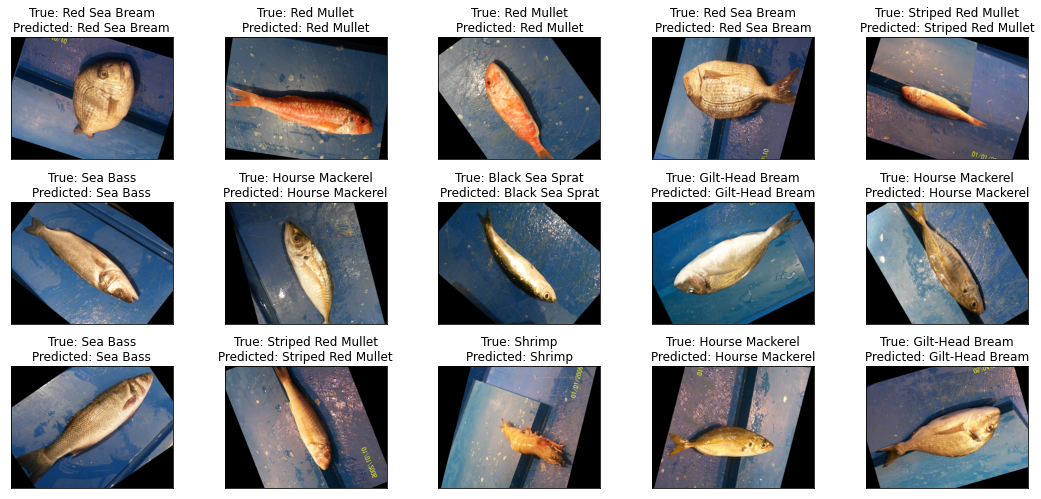

In [20]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [21]:
# Loading in some different test data downloaded from Google

image_dir = Path('../classifier/Test_images/')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
testi_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
testi_df = testi_df[testi_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [22]:
# Shuffle the DataFrame and reset index
testi_df = testi_df.sample(frac=1).reset_index(drop = True)

# Show the result
testi_df.head(3)

,Filepath,Label
0,..\classifier\Test_images\Ahven\3.png,Ahven
1,..\classifier\Test_images\Ahven\4.png,Ahven
2,..\classifier\Test_images\Ahven\5.png,Ahven


In [23]:
testi_kuvat = test_generator.flow_from_dataframe(
    dataframe=testi_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 13 validated image filenames belonging to 4 classes.


In [24]:
# Predict the label of the test_images
pred = model.predict(testi_kuvat)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
for i in range(10):
    print(f"True: {testi_df.Label.iloc[i]}\nPredicted: {pred[i]}")

1/1 [==============================] - 1s 503ms/step
True: Ahven
Predicted: Sea Bass
True: Ahven
Predicted: Sea Bass
True: Ahven
Predicted: Hourse Mackerel
True: Hauki
Predicted: Sea Bass
True: Ahven
Predicted: Trout
True: Ahven
Predicted: Sea Bass
True: Hauki
Predicted: Hourse Mackerel
True: Kuha
Predicted: Sea Bass
True: Sarki
Predicted: Sea Bass
True: Hauki
Predicted: Trout
